In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from DataMatrix import generate_data_matrix
from scipy.stats import mode
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
)

import warnings

warnings.filterwarnings("ignore")

In [ ]:
X_train1, y_train1, X_test1, y_test1 = generate_data_matrix(method="mean")
X_train2, y_train2, X_test2, y_test2 = generate_data_matrix(method="flatten")

X1 = X_test1
y1 = y_test1
X2 = X_test2
y2 = y_test2

number_of_clusters = 0

print("X_test shape: ", X_test1.shape)
print("y_train shape: ", y_train1.shape)
print("X_test shape: ", X_test1.shape)
print("y_test shape: ", y_test1.shape)

### DBSCAN Algorithm


In [ ]:
def get_DBSCAN(X, min_samples, eps):
    # Initialize labels
    labels = np.zeros(X.shape[0])

    # C is the cluster counter
    C = 0
    for i in range(X.shape[0]):

        # Skip if already labeled
        if labels[i] != 0:
            continue

        # Find neighbors within eps
        neighbors = np.where(np.linalg.norm(X - X[i], axis=1) <= eps)[0]

        # Mark as noise initially
        labels[i] = -1

        # If point is a core point, assign a cluster label
        if len(neighbors) >= min_samples:
            C += 1  # New cluster
            labels[i] = C  # Assign cluster label to core point
            S = list(
                neighbors
            )  # Set of points to potentially add to the current cluster

            j = 0
            while j < len(S):
                point = S[j]
                neighbors_j = np.where(np.linalg.norm(X - X[point], axis=1) <= eps)[0]

                # If the point is a core point, add its neighbors to S
                if len(neighbors_j) >= min_samples:
                    S += list(set(neighbors_j) - set(S))
                    labels[point] = C  # Assign cluster label to core point
                elif labels[point] == 0:
                    labels[point] = C  # Assign cluster label to border point

                j += 1
    # print("Number of clusters: ", C)
    return labels

#### Labels Mapping Function with Ground Truth Labels with Majority Voting


In [ ]:
def map_labels(y_true, y_pred):
    # Get the unique labels in y_pred
    unique_labels = np.unique(y_pred)

    # Create a dictionary to map the labels
    label_map = {}

    for label in unique_labels:
        if label != -1:  # Skip noise points
            # Find the indices of points in this cluster
            indices = np.where(y_pred == label)[0]

            # Get the actual labels of these points
            actual_labels = y_true[indices]

            # Find the most common actual label
            majority_label = mode(actual_labels).mode

            # If majority_label is an array, take the first element
            if isinstance(majority_label, np.ndarray):
                majority_label = majority_label[0]

            # Map the predicted label to the majority label
            label_map[label] = majority_label

    # Map the labels in y_pred
    y_pred = np.array([label_map.get(label, -1) for label in y_pred])

    return y_pred

#### Entropy Calculation Function


In [32]:
def construct_clusters(true_labels, labels):
    clusters = {}
    for i in range(len(true_labels)):
        if labels[i] in clusters:
            clusters[labels[i]].append(true_labels[i])
        else:
            clusters[labels[i]] = [true_labels[i]]
    return clusters


def entropy_score(clusters, n_samples):
    H = 0
    for cluster in clusters.values():
        n = len(cluster)
        s = -sum(
            [
                (cluster.count(label) / n) * np.log2(cluster.count(label) / n)
                for label in set(cluster)
            ]
        )
        H += (n / n_samples) * s
    return H

### Hyperparamters


In [ ]:
n_samples = 2
eps = 1.8

### Implemented DBSCAN


#### Method 1 (Mean)


In [33]:
y_pred = get_DBSCAN(X1, n_samples, eps)
y_pred_mapped = map_labels(y1, y_pred)


clusters = construct_clusters(y1, y_pred_mapped)

precision = precision_score(y1, y_pred_mapped, average="weighted")
recall = recall_score(y1, y_pred_mapped, average="weighted")
f1 = f1_score(y1, y_pred_mapped, average="weighted")
entropy = entropy_score(clusters, len(X1))

mean_precision = precision
mean_recall = recall
mean_f1 = f1
mean_entropy = entropy

print("Implemented DBSCAN Evaluation Metrics:")
print("Precision: {:.3f}%".format(precision * 100))
print("Recall:    {:.3f}%".format(recall * 100))
print("F1-Score:  {:.3f}%".format(f1 * 100))
print("Entropy:   {:.3f}".format(entropy))

Implemented DBSCAN Evaluation Metrics:
Precision: 92.150%
Recall:    70.998%
F1-Score:  76.615%
Entropy:   0.988


#### Method 2 (Flatten)


In [34]:
y_pred = get_DBSCAN(X2, n_samples, eps)
y_pred_mapped = map_labels(y2, y_pred)

clusters = construct_clusters(y2, y_pred_mapped)

precision = precision_score(y2, y_pred_mapped, average="weighted")
recall = recall_score(y2, y_pred_mapped, average="weighted")
f1 = f1_score(y2, y_pred_mapped, average="weighted")
entropy = entropy_score(clusters, len(X2))
flatten_precision = precision
flatten_recall = recall
flatten_f1 = f1
flatten_entropy = entropy

print("Implemented DBSCAN Evaluation Metrics:")
print("Precision: {:.3f}%".format(precision * 100))
print("Recall:    {:.3f}%".format(recall * 100))
print("F1-Score:  {:.3f}%".format(f1 * 100))
print("Entropy:   {:.3f}".format(entropy))

Implemented DBSCAN Evaluation Metrics:
Precision: 26.316%
Recall:    20.888%
F1-Score:  21.914%
Entropy:   3.144


### DBSCAN in Scikit-Learn


#### Method 1 (Mean)


In [35]:
dbscan1 = DBSCAN(eps=eps, min_samples=n_samples)

# Fit the model to the data
dbscan1.fit(X1)

# Print the cluster labels for each data point
y_pred_sklearn = dbscan1.labels_
num_clusters = len(np.unique(y_pred_sklearn[y_pred_sklearn != -1]))
y_pred_sklearn_mapped = map_labels(y1, y_pred_sklearn)

clusters = construct_clusters(y1, y_pred_sklearn_mapped)

precision = precision_score(y1, y_pred_sklearn_mapped, average="weighted")
recall = recall_score(y1, y_pred_sklearn_mapped, average="weighted")
f1 = f1_score(y1, y_pred_sklearn_mapped, average="weighted")
entropy = entropy_score(clusters, len(X1))

print("Sklearn DBSCAN Evaluation Metrics:")
print("Precision: {:.3f}%".format(precision * 100))
print("Recall:    {:.3f}%".format(recall * 100))
print("F1-Score:  {:.3f}%".format(f1 * 100))
print("Entropy:   {:.3f}".format(entropy))

Sklearn DBSCAN Evaluation Metrics:
Precision: 92.150%
Recall:    70.998%
F1-Score:  76.615%
Entropy:   0.988


#### Method 2 (Flatten)


In [36]:
dbscan2 = DBSCAN(eps=eps, min_samples=n_samples)

# Fit the model to the data
dbscan2.fit(X2)

# Print the cluster labels for each data point
y_pred_sklearn = dbscan2.labels_
num_clusters = len(np.unique(y_pred_sklearn[y_pred_sklearn != -1]))
y_pred_sklearn_mapped = map_labels(y2, y_pred_sklearn)

clusters = construct_clusters(y2, y_pred_sklearn_mapped)

precision = precision_score(y2, y_pred_sklearn_mapped, average="weighted")
recall = recall_score(y2, y_pred_sklearn_mapped, average="weighted")
f1 = f1_score(y2, y_pred_sklearn_mapped, average="weighted")
entropy = entropy_score(clusters, len(X2))

print("Sklearn DBSCAN Evaluation Metrics:")
print("Precision: {:.3f}%".format(precision * 100))
print("Recall:    {:.3f}%".format(recall * 100))
print("F1-Score:  {:.3f}%".format(f1 * 100))
print("Entropy:   {:.3f}".format(entropy))

Sklearn DBSCAN Evaluation Metrics:
Precision: 26.316%
Recall:    20.888%
F1-Score:  21.914%
Entropy:   3.144


### Comparison Between Method 1 (Mean) and Method 2 (Flatten)


#### precision


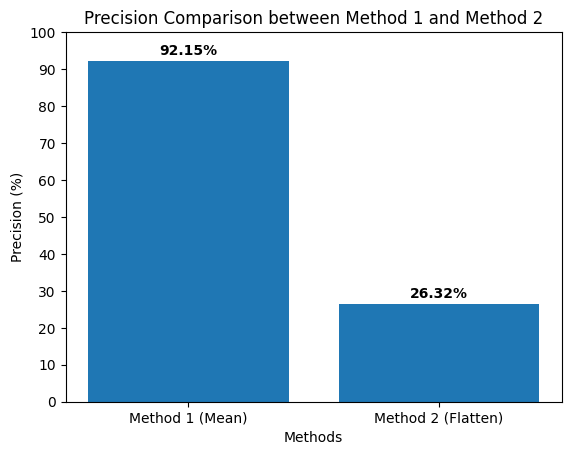

In [37]:
# Define the precisions
precisions = [mean_precision * 100, flatten_precision * 100]  # Convert to percentages

# Define the method names
methods = ["Method 1 (Mean)", "Method 2 (Flatten)"]

# Create the bar chart
bars = plt.bar(methods, precisions)

# Add the precision values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 1,
        f"{yval:.2f}%",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

plt.xlabel("Methods")
plt.ylabel("Precision (%)")  # Indicate that precision is in percentages
plt.title("Precision Comparison between Method 1 and Method 2")
plt.yticks(np.arange(0, 101, 10))  # Set y-axis ticks from 0 to 100
plt.show()

#### recall


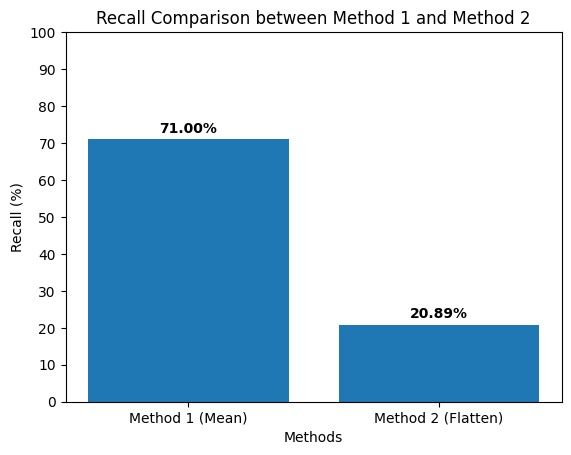

In [38]:
# Define the recalls
recalls = [mean_recall * 100, flatten_recall * 100]  # Convert to percentages

# Create the bar chart
bars = plt.bar(methods, recalls)

# Add the recall values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 1,
        f"{yval:.2f}%",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

plt.xlabel("Methods")
plt.ylabel("Recall (%)")  # Indicate that recall is in percentages
plt.title("Recall Comparison between Method 1 and Method 2")
plt.yticks(np.arange(0, 101, 10))  # Set y-axis ticks from 0 to 100
plt.show()

#### f1-score


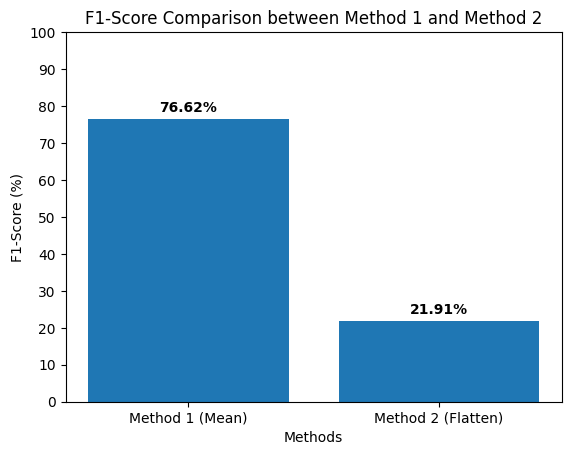

In [39]:
# Define the F1-scores
f1_scores = [mean_f1 * 100, flatten_f1 * 100]  # Convert to percentages

# Create the bar chart
bars = plt.bar(methods, f1_scores)

# Add the F1-score values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 1,
        f"{yval:.2f}%",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

plt.xlabel("Methods")
plt.ylabel("F1-Score (%)")  # Indicate that F1-score is in percentages
plt.title("F1-Score Comparison between Method 1 and Method 2")
plt.yticks(np.arange(0, 101, 10))  # Set y-axis ticks from 0 to 100
plt.show()

#### conditional entropy

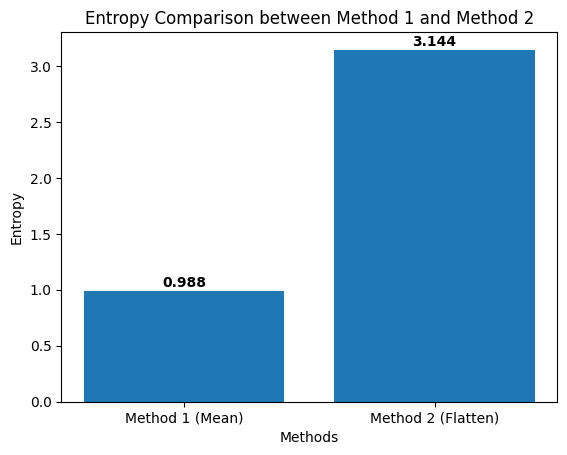

In [40]:
# Define the entropies
entropies = [mean_entropy, flatten_entropy]

# Create the bar chart
bars = plt.bar(methods, entropies)

# Add the entropy values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 0.01,
        f"{yval:.3f}",
        ha="center",
        va="bottom",
        fontweight="bold",
    )
    
plt.xlabel("Methods")
plt.ylabel("Entropy")  # Indicate that entropy is in percentages
plt.title("Entropy Comparison between Method 1 and Method 2")
plt.show()